# How to Detect Fake and Real News with Natural Language Processing
> An NLP guide to text classification with GloVe word embedding, and Deep Learning

- toc: true 
- badges: true
- comments: true
- categories: [nlp]

![](https://github.com/Sepiafs/sepidehdoost/blob/master/_notebooks/images/fakenews.jpg?raw=1)

I have recently taken a great NLP course by deeplearning.ai (Andrew Ng) called "Sequence Models". I always like to start a new project after learning a new skill. So, I found this interesting dataset in Kaggle [Fake and real news dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). The objective is to make an algorithm able to determine if an article is fake news or not.

I applied my learnings on this dataset and hope in this way I can share what I learned with you. 

# Solution Framework
There are two csv files in this Kaggle datatset each containing a list of articles considered as "fake" and "real" news.

The picture below shows the steps we will be taking in order. We'll explain the details of each step throughout the notebook.

![](https://github.com/Sepiafs/sepidehdoost/blob/master/_notebooks/images/solutionframework.png?raw=1)






In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/glove42b300dtxt/glove.42B.300d.txt


## Loading the required libraries

In [ ]:
#for data analysis and modeling
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#for text cleaning
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for visualization
import matplotlib.pyplot as plt


# Loading data and visualizing

In [ ]:
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Combine fake and true dataframes
Create a new column 'truth' showing whethere the news is fake or real. Then, concatenate two datasets into one dataframe. We can choose to use either 'title' or 'text' column or concatenated 'title+text' for training. But, for the sake of processing time, we'll only use 'title'.


In [ ]:
true['truth'] = 1
fake['truth'] = 0
df = pd.concat([true, fake], axis=0, ignore_index=True)
df.shape

(44898, 5)

# Text Cleaning

We need to clean the text first. If you start searching on the text cleaning domain, you realize there are many different techniques. But you may need just a few methods for the purpose of your NLP task. 
<br>
<br>
There are many good resources for text clearning. But, I mainly looked up the following resources for my text cleaning in this notebook: <br>
https://machinelearningmastery.com/clean-text-machine-learning-python/ <br>
https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/<br>
<br>
Here are 5 steps that give decent text cleaning result for this task:<br>
1.	<b>Replace contractions</b><br>
In English, a contraction is a word or phrase that has been shortened by dropping one or more letters, such as “I’m” instead of “I am”. We can either split the contractions (“I’m” to “ I ”+” ’m ”) or convert them to their full format (“I’m ” to “I am”). In my experience the latter works better as it's harder to find a word embedding for sub-words like “ ‘m “.<br>
<br>
2.	<b>Removing punctuation</b><br>
We want the sentences without punctuations like commas, brackets, etc. Python has a constant called string.punctuation that provides a list of punctuation characters. We’ll use this list to clean our text from punctuations.<br>
<br>
3.	<b>Splitting into words</b><br>
In order to remove stopwords, we first need to split the text into words. We do this with word_tokenize function by NLTK. This function splits the text based on white space and punctuation.<br>
<br>
4.	<b>Removing stopwords</b><br>
Stopwords are common words like “the”, “and”, … which don’t add much value to the meaning of the text. NLTK has a list of these words that can be imported and used to remove them from the text.<br>
<br>
5.	<b>Removing leftover punctuations</b><br>
I noticed after all this cleaning, there were still some words like “…but” with dots in them. I added this last step to clean them up. <br>
<br>
Normalizing by case is also common practice. But, since we are using keras tokenizer later, we can skip this step as tokenizer does this step by default. There are other preprocessing techniques of text like Stemming, and Lemmatization. However, in the realm of deep learning NLP they are not necessary anymore. 


In [ ]:
%%time
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df['data_cleaned'] = df['title'].apply(lambda txt: clean_text(txt))


CPU times: user 20.4 s, sys: 751 ms, total: 21.1 s
Wall time: 21.2 s


In [ ]:
df['data_cleaned']

0        As US budget fight looms Republicans flip fisc...
1        US military accept transgender recruits Monday...
2          Senior US Republican senator Let Mr Mueller job
3        FBI Russia probe helped Australian diplomat ti...
4        Trump wants Postal Service charge much Amazon ...
                               ...                        
44893    McPain John McCain Furious That Iran Treated U...
44894    JUSTICE Yahoo Settles Email Privacy Classactio...
44895    Sunnistan US Allied Safe Zone Plan Take Territ...
44896    How Blow Million Al Jazeera America Finally Ca...
44897    US Navy Sailors Held Iranian Military Signs Ne...
Name: data_cleaned, Length: 44898, dtype: object

# Prepare train and test datasets

Use the usual train_test_split by sklearn to split the data. 

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['truth'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 227


## Tokenize the input training sentences 

In most of the NLP tasks, we need to represent each word in the text with an integer value (index) before feeding it to any model. In this way, the text will be converted to a sequence of integer values. One of the ways of doing that is with Keras. Keras provides an API for tokenizing the text. Tokenizer in Keras finds the frequency of each unique word and sort them based on their frequency. It then assigns an integer value starting from 1 to each word from the top.  You can see the index mapping dictionary by reading tokenizer.word_index.
 
There are two distinct steps in tokenizing in this way:
1. fit_on_texts: We'll fit the tokenizer on our training data to create the word indices
2. texts_to_sequences: using the word index dictionary from step above, we take this step to transform both train and test data. 

Here, we set num_words to a limit such as 10000 words. num_words is a parameter that defines the maximum number of words to keep, based on the word frequency. Keras actually keeps (num_words-1) words. We can leave the num_words to 'None' and tokenizer will pick all the words in the vacabulary. 

## Padding and truncating the input training sequences
All your input sequences to the model need to have the same length. In order to achieve that, we can use a function that pads the short sequences with zeros (options are 'pre' or 'post' which pads either before or after each sequence). It also truncates any sequence that is longer than a predefined parameter "maxlen". Truncating also has the option of 'pre' or 'post' which either truncates at the beginning or at the end of the sequences. 

In [ ]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: As US budget fight looms Republicans flip fiscal script
sequence of indices(before padding): [47, 2455, 615, 996, 3704, 118, 2692, 3534]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  

# Word embedding using pre-trained GloVe vectors

Now that we have tokenized the text, we use GloVe pretrained vectors. Word embeddings is a way to represent words with similar meaning to have a similar representation.  Using word embedding through GloVe, we can have a decent performance with models with even relatively small label training sets. 

You can download GloVe pre-trained word vectors from the link below. There are different sizes of vocabulary and embedding dimension available. 

https://nlp.stanford.edu/projects/glove/


## Load the GloVe vectors

In [ ]:
%%time
embedding_vectors = {}
# with open('/kaggle/input/glove6b100d/glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('/kaggle/input/glove42b300dtxt/glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   


Size of vocabulary in GloVe: 1917494
CPU times: user 4min 21s, sys: 6.44 s, total: 4min 27s
Wall time: 4min 27s


## Create an embedding matrix with the GloVe vectors

The embedding matrix has a shape of (vocabulary length, embedding dimension). 

Note tht vacab_len is equal to max_words if we set that limit when tokenizing. Otherwise, vocab_len is equal to lenght of all words in word_index+1. 

Each row of the embedding matrix belongs to one word in the vocabulary (derived from xtrain) and it contains the weights of embedding vector of that word. <br>

In the code below, we initialze the embedding matrix with zeros. If a word in our word_index is not found in the embedding vectors from GloVe. 

The weight of that word remains as zero. Below, you can see print out of the some example words that are out of vacabulary (OOV). 

In [ ]:
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['brexit', 'antitrump', 'reutersipsos', 'protrump', 'blacklivesmatter']


In [ ]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

210 out of 10000 words were OOV.


# Modeling
Now, we can create a model and pre-train the embedding layer with the embedding matrix we just created based on GloVe vectors. You can see the [model overview](#model_overview) below. 

The model architecture looks like the picture below. Although tokenizing is not part of the modeling, it's nice to show that this step is taken before feeding the text data to the LSTM models. This model is similar to one of the programming assignments in the "Sequence model" course. But, one of the LSTM layers are removed as it turned out that adding that extra layer doesn't help and even cause some overfitting. 


The first layer of the model is Embedding. Embedding layer by Keras is a flexible layer that can be used also without any pre-trained weights. In that case, the Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. In this exercise, we will set the weights of the Embedding layer to the embedding matrix from GloVe pre-trained vectors.This is a tranfer learning. 

Another parameter in Embedding layer is "trainable" which can be set to True in case you want to fine-tune the word embedding or if you don't want the embedding weights to be updated you can set it to False. Here, we set it to False.<br>

After the Embedding layer, we have a layer of LSTM or GRU and then a Dropout layer for regularization. 

Then we have a Dense layer with Sigmoid activation which transforms the output of previous layers to 0 or 1 (real or fake). 


<a id='model_overview'></a>
## Model Overview

![](https://github.com/Sepiafs/sepidehdoost/blob/master/_notebooks/images/modelarchitecture.png?raw=1)

## LSTM
Let's start with LSTM models.

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,219,777
Trainable params: 219,777
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [ ]:
%%time
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Train on 35918 samples, validate on 8980 samples
Epoch 1/10
35918/35918 [==============================] - 12s 330us/sample - loss: 0.1254 - accuracy: 0.9511 - val_loss: 0.0745 - val_accuracy: 0.9731
Epoch 2/10
35918/35918 [==============================] - 6s 179us/sample - loss: 0.0572 - accuracy: 0.9798 - val_loss: 0.0554 - val_accuracy: 0.9812
Epoch 3/10
35918/35918 [==============================] - 6s 179us/sample - loss: 0.0431 - accuracy: 0.9850 - val_loss: 0.0575 - val_accuracy: 0.9791
Epoch 4/10
35918/35918 [==============================] - 6s 180us/sample - loss: 0.0324 - accuracy: 0.9894 - val_loss: 0.0479 - val_accuracy: 0.9827
Epoch 5/10
35918/35918 [==============================] - 7s 185us/sample - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0436 - val_accuracy: 0.9852
Epoch 6/10
35918/35918 [==============================] - 7s 188us/sample - loss: 0.0184 - accuracy: 0.9940 - val_loss: 0.0432 - val_accuracy: 0.9853
Epoch 7/10
35918/35918 [==========================

## LSTM - Evaluation

Let's find the accuracy of training and testing dataset below:

Text(0.5, 1.0, 'Accuracy')

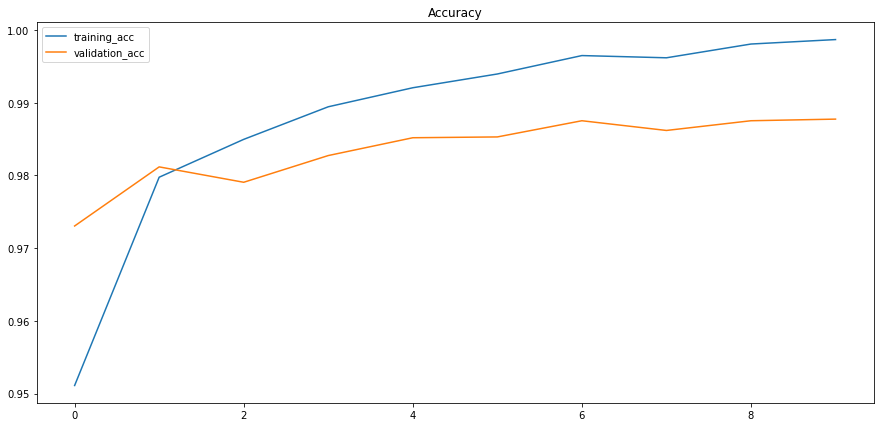

In [ ]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [ ]:

train_lstm_results = lstm_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

Train accuracy: 99.92
Test accuracy: 98.78


## GRU

In [ ]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,165,249
Trainable params: 165,249
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [ ]:

batch_size = 256
epochs  = 10
history = gru_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Train on 35918 samples, validate on 8980 samples
Epoch 1/10
35918/35918 [==============================] - 8s 226us/sample - loss: 0.1344 - accuracy: 0.9450 - val_loss: 0.0675 - val_accuracy: 0.9762
Epoch 2/10
35918/35918 [==============================] - 6s 179us/sample - loss: 0.0587 - accuracy: 0.9803 - val_loss: 0.0536 - val_accuracy: 0.9820
Epoch 3/10
35918/35918 [==============================] - 7s 184us/sample - loss: 0.0445 - accuracy: 0.9855 - val_loss: 0.0480 - val_accuracy: 0.9836
Epoch 4/10
35918/35918 [==============================] - 7s 183us/sample - loss: 0.0323 - accuracy: 0.9893 - val_loss: 0.0411 - val_accuracy: 0.9856
Epoch 5/10
35918/35918 [==============================] - 6s 179us/sample - loss: 0.0227 - accuracy: 0.9922 - val_loss: 0.0392 - val_accuracy: 0.9880
Epoch 6/10
35918/35918 [==============================] - 6s 180us/sample - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0390 - val_accuracy: 0.9875
Epoch 7/10
35918/35918 [===========================

## GRU Evaluation

Let's find the accuracy of training and testing dataset with GRU model below:

Text(0.5, 1.0, 'Accuracy')

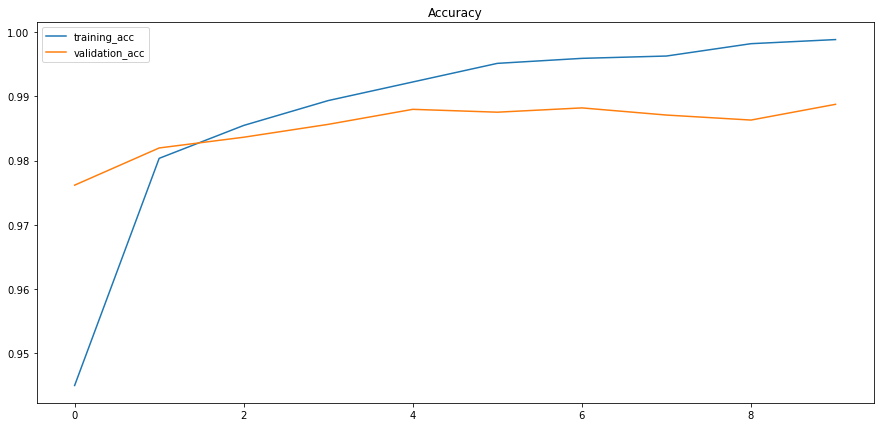

In [ ]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [ ]:
train_gru_results = gru_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 99.96
Test accuracy: 98.88


As you can see in this example both GRU and LSTM perform similarly. Given the lower complexity of GRU, perhaps GRU is a better choice here. 

There you have it. You learned all steps required to write a text classifier using pre-trained word embeddings such as GloVe and an LSTM or GRU model. 

**Let me know if you have any suggestions to improve this notebook.  Thank you. **